In [5]:
import cv2 as cv
import sys
import os
from matplotlib import pyplot as plt

import numpy as np
from tensorflow.keras import models, layers, optimizers, utils, Input
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.utils import np_utils #to_categorical
from sklearn.model_selection import KFold
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import accuracy_score, precision_score,f1_score,recall_score

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
path='/content/drive/MyDrive/03_iris_training'

#786 576

images = []
labels = []

def img_trim (img):     
    x = 150; y = 90;
    w = 476; h = 430;
    img_trim = img[y:y+h, x:x+w]
    return img_trim

def crop_images(path, images):
    for img in os.listdir(path):
      img_array = cv.imread(os.path.join(path, img))/255.0
      img_array = cv.resize(img_trim(img_array), (0,0), fx=0.1, fy=0.1)
      images.append(img_array)
      label = np_utils.to_categorical(int(img[:3])-1, 64)
      labels.append(label)
    

crop_images(path, images)

In [8]:
images = np.array(images)
labels = np.array(labels)

print(images.shape)

(128, 43, 48, 3)


In [ ]:
from keras.preprocessing.image import ImageDataGenerator

trainDataGen = ImageDataGenerator(
                                 width_shift_range=0.05,      #수평방향 이동
                                 height_shift_range=0.05,     #수직방향 이동
                                 brightness_range=[0.7, 1.3]  #밝기 변화
                                 )


In [ ]:
path2='/content/drive/MyDrive/aug'
i = 2
j = 0
im=[]

for img in images :
    im.append(img)
    im=np.array(im)
    for batch in trainDataGen.flow(im, batch_size=1, save_to_dir=path2, save_prefix=format(int(i/2),'03'), save_format='png'):
        j += 1
        if j > 7:
            break
    j = 0
    i+=1
    im=[]

In [9]:
path2='/content/drive/MyDrive/aug'
def append_images(path, images, labels):
    a=1
    for img in os.listdir(path):
        img_array = cv.imread(os.path.join(path, img))
        images = np.append(images, [img_array], axis = 0)
        label = np_utils.to_categorical(int(img[:3])-1, 64)
        labels = np.append(labels, [label], axis=0)
    return images, labels
        
images, labels = append_images(path2, images, labels)

In [10]:
print(images.shape)

(1152, 43, 48, 3)


In [11]:
model = models.Sequential()  # 레이어를 층층히 쌓아가는 연쇄 모델

input = Input(shape=(43, 48, 3))

model.add(ResNet50(input_tensor=input, include_top=False, weights='imagenet', pooling='max'))

model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(128, activation='relu', kernel_initializer='he_normal'))
model.add(layers.BatchNormalization())
model.add(layers.Dense(64, activation='softmax'))

model.compile(optimizer='adam',
              loss='categorical_crossentropy', 
              metrics=['accuracy'])


In [4]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               524544    
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
batch_normalization (BatchNo (None, 128)               512       
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
Total params: 24,153,920
Trainable params: 24,100,544
Non-trainable params: 53,376
_______________________________________

In [12]:
model = models.Sequential()  # 레이어를 층층히 쌓아가는 연쇄 모델

model.add(layers.Conv2D(filters = 32, kernel_size = (3,3), padding='Same', activation='relu'))
model.add(layers.MaxPooling2D(pool_size = (2,2)))
model.add(layers.Dropout(0.1))

model.add(layers.Conv2D(filters = 32, kernel_size = (3,3), padding='Same', activation='relu'))
model.add(layers.AveragePooling2D(pool_size = (2,2)))
model.add(layers.Dropout(0.1))

model.add(layers.Conv2D(filters = 64, kernel_size = (3,3), padding='Same', activation='relu'))
model.add(layers.AveragePooling2D(pool_size = (2,2)))
model.add(layers.Dropout(0.1))

model.add(layers.Conv2D(filters = 128, kernel_size = (3,3), padding='Same', activation='relu'))
model.add(layers.MaxPooling2D(pool_size = (2,2)))

model.add(layers.Flatten())
model.add(layers.Dense(50, kernel_initializer='he_normal'))
model.add(layers.BatchNormalization())
model.add(layers.Dense(64, activation='softmax'))

model.compile(optimizer='adam',
              loss='categorical_crossentropy', 
              metrics=['accuracy'])


In [13]:
#Cross validation
num = 6
cross = KFold(n_splits = num, shuffle = True, random_state = 2021)
accs = [];  precision = [];  recall = [];  F1 = []
history = []
i = 0


for train_index,test_index in cross.split(images, labels):
    #훈련용
    x_train = images[train_index] 
    y_train = labels[train_index] 
    #검증용
    x_test = images[test_index] 
    y_test = labels[test_index] 
    
    i += 1    
    print('Fold' + str(i))
    
    #훈련용에 대해 model 학습시키고()
    history.append(model.fit(x_train, y_train, epochs = 250, batch_size = 32))
    
    y_test = np.argmax(y_test,axis = 1)
    pred = np.argmax(model.predict(x_test).round(), axis = 1)
    
    print('실제 : ', y_test)
    print('예측 : ', pred)
    print('-------------------------------------------------------------------------------')
    
    #test로 model 검증(1)
    accs.append(accuracy_score(y_test, pred))
    precision.append(precision_score(y_test,pred, average = 'macro'))
    recall.append(recall_score(y_test, pred, average = 'macro',  labels=np.unique(pred)))
    F1.append(f1_score(y_test, pred, average = 'macro',  labels=np.unique(pred)))

Fold1
Epoch 1/250
30/30 [==============================] - 32s 5ms/step - loss: 4.1438 - accuracy: 0.0573
Epoch 2/250
30/30 [==============================] - 0s 5ms/step - loss: 3.5695 - accuracy: 0.1208
Epoch 3/250
30/30 [==============================] - 0s 5ms/step - loss: 3.1449 - accuracy: 0.2542
Epoch 4/250
30/30 [==============================] - 0s 4ms/step - loss: 2.7325 - accuracy: 0.3688
Epoch 5/250
30/30 [==============================] - 0s 5ms/step - loss: 2.3200 - accuracy: 0.4948
Epoch 6/250
30/30 [==============================] - 0s 4ms/step - loss: 1.9030 - accuracy: 0.6313
Epoch 7/250
30/30 [==============================] - 0s 4ms/step - loss: 1.5804 - accuracy: 0.7281
Epoch 8/250
30/30 [==============================] - 0s 4ms/step - loss: 1.2810 - accuracy: 0.7979
Epoch 9/250
30/30 [==============================] - 0s 4ms/step - loss: 1.0684 - accuracy: 0.8271
Epoch 10/250
30/30 [==============================] - 0s 4ms/step - loss: 0.8857 - accuracy: 0.8677
Ep

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


30/30 [==============================] - 0s 5ms/step - loss: 0.0796 - accuracy: 0.9781
Epoch 2/250
30/30 [==============================] - 0s 5ms/step - loss: 0.0805 - accuracy: 0.9781
Epoch 3/250
30/30 [==============================] - 0s 4ms/step - loss: 0.0690 - accuracy: 0.9781
Epoch 4/250
30/30 [==============================] - 0s 4ms/step - loss: 0.0365 - accuracy: 0.9875
Epoch 5/250
30/30 [==============================] - 0s 4ms/step - loss: 0.0344 - accuracy: 0.9865
Epoch 6/250
30/30 [==============================] - 0s 4ms/step - loss: 0.0346 - accuracy: 0.9927
Epoch 7/250
30/30 [==============================] - 0s 4ms/step - loss: 0.0271 - accuracy: 0.9937
Epoch 8/250
30/30 [==============================] - 0s 4ms/step - loss: 0.0246 - accuracy: 0.9937
Epoch 9/250
30/30 [==============================] - 0s 4ms/step - loss: 0.0114 - accuracy: 0.9979
Epoch 10/250
30/30 [==============================] - 0s 4ms/step - loss: 0.0139 - accuracy: 0.9969
Epoch 11/250
30/30 [=

In [14]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (32, 43, 48, 32)          896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (32, 21, 24, 32)          0         
_________________________________________________________________
dropout (Dropout)            (32, 21, 24, 32)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            (32, 21, 24, 32)          9248      
_________________________________________________________________
average_pooling2d (AveragePo (32, 10, 12, 32)          0         
_________________________________________________________________
dropout_1 (Dropout)          (32, 10, 12, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (32, 10, 12, 64)         

In [15]:
for i in range(1,num+1):
    print("Fold%d 훈련 결과 : "%i)
    print("     accs : %.6f"%accs[i-1])
    print("     precision : %.6f"%precision[i-1])
    print("     recall : %.6f"%recall[i-1])
    print("     F1 : %.6f"%F1[i-1])

print("\n평균 훈련 결과")
print("     Accuracy : %.6f"%np.mean(accs))
print("     Precision : %.6f"%np.mean(precision))
print("     Recall Score : %.6f"%np.mean(recall))
print("     F1-Score : %.6f"%np.mean(F1))

Fold1 훈련 결과 : 
     accs : 0.958333
     precision : 0.929032
     recall : 0.952619
     F1 : 0.950132
Fold2 훈련 결과 : 
     accs : 1.000000
     precision : 1.000000
     recall : 1.000000
     F1 : 1.000000
Fold3 훈련 결과 : 
     accs : 0.994792
     precision : 0.996774
     recall : 0.997696
     F1 : 0.996967
Fold4 훈련 결과 : 
     accs : 0.994792
     precision : 0.997268
     recall : 0.996721
     F1 : 0.996688
Fold5 훈련 결과 : 
     accs : 1.000000
     precision : 1.000000
     recall : 1.000000
     F1 : 1.000000
Fold6 훈련 결과 : 
     accs : 1.000000
     precision : 1.000000
     recall : 1.000000
     F1 : 1.000000

평균 훈련 결과
     Accuracy : 0.991319
     Precision : 0.987179
     Recall Score : 0.991173
     F1-Score : 0.990631


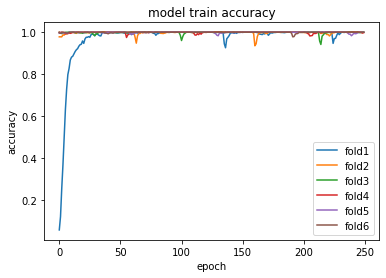

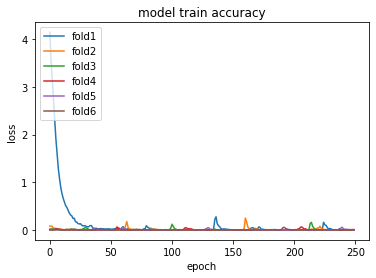

In [16]:
# summarize history for accuracy
plt.plot(history[0].history['accuracy'])
plt.plot(history[1].history['accuracy'])
plt.plot(history[2].history['accuracy'])
plt.plot(history[3].history['accuracy'])
plt.plot(history[4].history['accuracy'])
plt.plot(history[5].history['accuracy'])
plt.title('model train accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['fold1', 'fold2','fold3','fold4','fold5','fold6'], loc=0)
plt.show()

# summarize history for accuracy
plt.plot(history[0].history['loss'])
plt.plot(history[1].history['loss'])
plt.plot(history[2].history['loss'])
plt.plot(history[3].history['loss'])
plt.plot(history[4].history['loss'])
plt.plot(history[5].history['loss'])
plt.title('model train accuracy')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['fold1', 'fold2','fold3','fold4','fold5','fold6'], loc='upper left')
plt.show()


In [17]:
path='/content/drive/MyDrive/03_iris_test'

test_num = []
test_images = []
def crop_test_images(path, test_images):
    for img in os.listdir(path):
      img_array = cv.imread(os.path.join(path, img))/255.0
      img_array = cv.resize(img_trim(img_array), (0,0), fx=0.1, fy=0.1)    
      test_images.append(img_array)
      test_num.append(int(os.path.splitext(img)[0]))
        
        
crop_test_images(path, test_images)

In [18]:
test_images = np.array(test_images)
test_num = np.array(test_num)

In [19]:
import pandas as pd

pred = np.argmax(model.predict(test_images).round(), axis=1) + 1

df = pd.DataFrame({'Image': test_num, 'Answer': pred}).sort_values('Image')
df.to_csv('/content/drive/MyDrive/결과/1871081_이희연_홍채_2차_답안csv', index = False)